In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from matplotlib.pyplot import figure
import math as m
from segment import Segment
from func import *
from numba import njit

In [131]:
NUM_PORTS = 4
SIZE = 100
imp0 = 377
connect = 50
tau = 0.3
# kappa = 1j* m.sqrt(1-tau**2) # not working yet for complex number

maxTime = 2000

rings_no = 4
N_seg = rings_no*2

# sources = [[-1,-1],[0,2],[3,5],[2,0],[5,3],[2,4]]
# couplings = [[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa]]

sources = Sources(rings_no)  #working for any number of rings
couplings = Couplings(rings_no, tau)

print(sources)
# print(couplings)
ez_tab = np.zeros([N_seg, maxTime, SIZE], dtype=complex)

[[-1 -1]
 [ 0  3]
 [ 3  0]
 [ 2  5]
 [ 5  2]
 [ 4  7]
 [ 7  4]
 [ 6  5]]


In [132]:

# s = Sources(rings_no)
# print(s)

# c = Couplings(rings_no, tau)
# print(c)



In [133]:
f_array = []

for ii in range(N_seg):
    f = Segment(SIZE)
    f_array.append(f)
# print(f_array)

for qTime in range(maxTime):
    s = cosMod(qTime, maxTime)
    # print(s)
    
    for ii in range(N_seg):
        s1 = sources[ii][0]
        s2 = sources[ii][1]
        tau_ = couplings[ii][0]
        kappa_ = couplings[ii][1]
        
        # print(s1,s2)
        # print(tau_, kappa_)
        
       
        if (sources[ii][0] == -1):
            s_new = s
            xs = connect
        else:
            s_new = tau_*f_array[s1].ez[-1] + kappa_*f_array[s2].ez[-1]
            xs = 2 
            
        # print(s_new)
        
        f_array[ii].hy_update()
        f_array[ii].hy_sources(s_new,xs)
        f_array[ii].ez_update()
        f_array[ii].ez_sources(s_new,xs)
        

        ez_tab[ii,qTime,:] = f_array[ii].ez[:]   

for ii in range(N_seg):
    filename = f"ez_tab_{ii:04d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
    np.savetxt(filename, ez_tab[ii, :, :], delimiter=",")

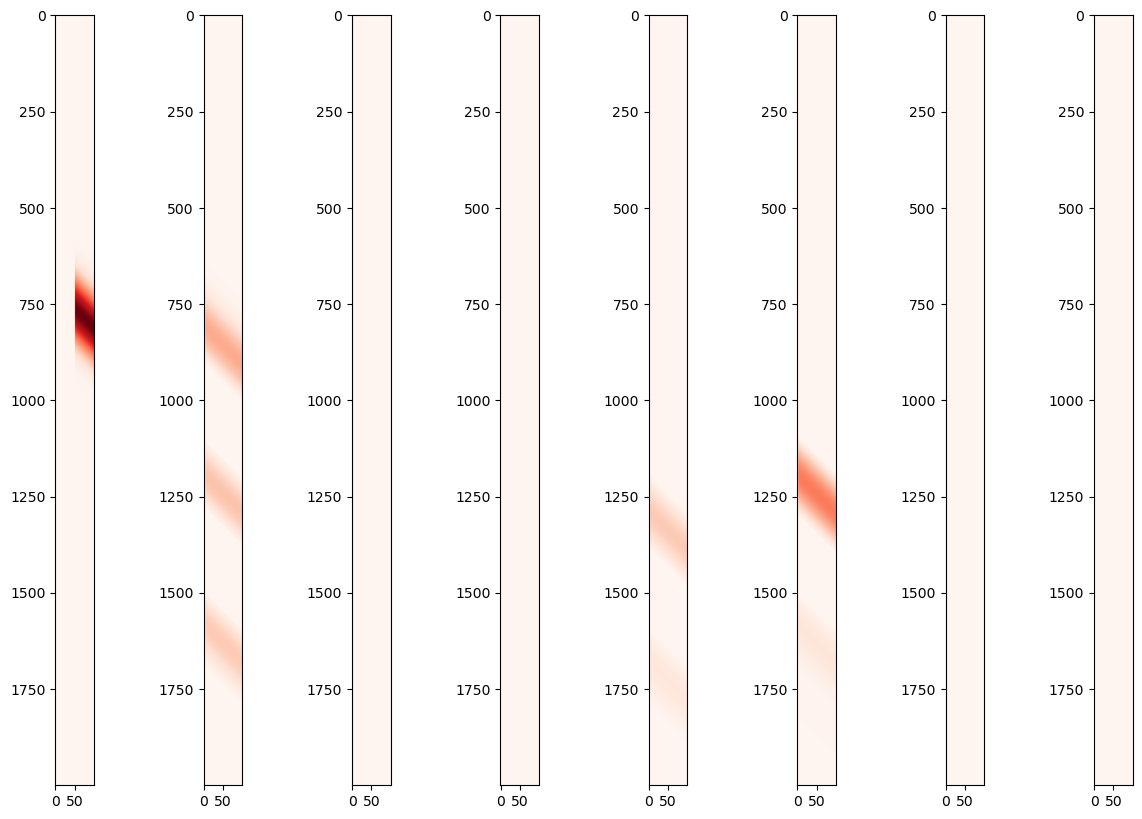

In [134]:
f, ax = plt.subplots(1,N_seg, figsize=(15,10)) 

vmax_val = np.max(np.real(ez_tab[0,:,:]))

for ii in range(N_seg):
    ax[ii].imshow(np.real(ez_tab[ii,:,:]), vmin = 0, vmax = vmax_val , cmap = 'Reds')
# plt.savefig("ez_real.png")

# f, ax2 = plt.subplots(1,6, figsize=(10,15)) 
# for ii in range(6):
#     ax2[ii].imshow(np.imag(ez_tab[ii,:,:]), vmin = 0, vmax = vmax_val , cmap = 'Reds')
# plt.savefig("ez_imag.png")

# f, ax3 = plt.subplots(1,6, figsize=(10,15)) 
# for ii in range(6):
#     ax3[ii].imshow(abs(ez_tab[ii,:,:]), vmin = 0, vmax = vmax_val , cmap = 'Reds')
# plt.savefig("ez_abs.png")
# plt.plot(ez_tab[:,15])

range(0, 100)


c:\Users\Mitali\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Mitali\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


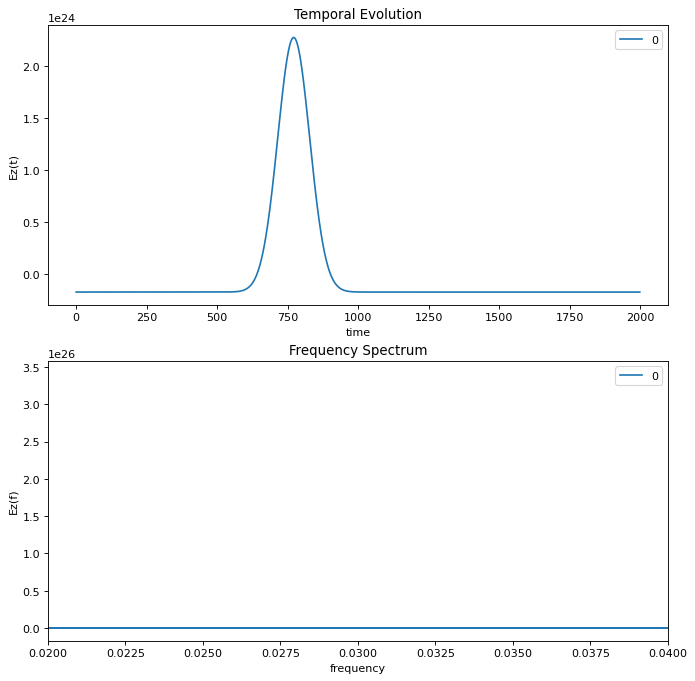

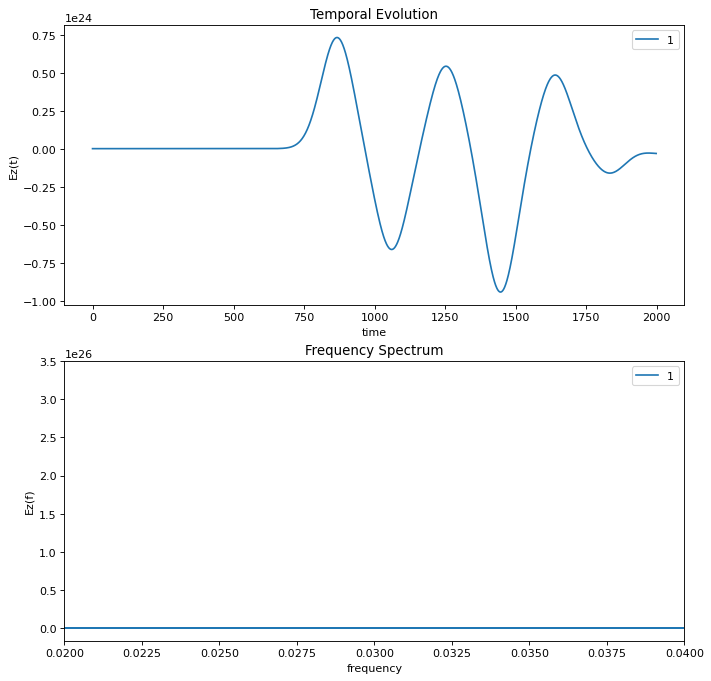

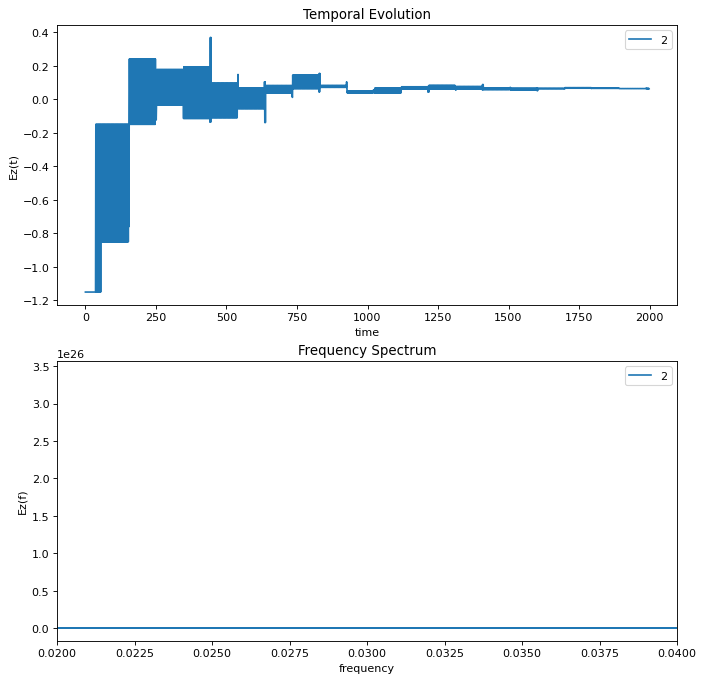

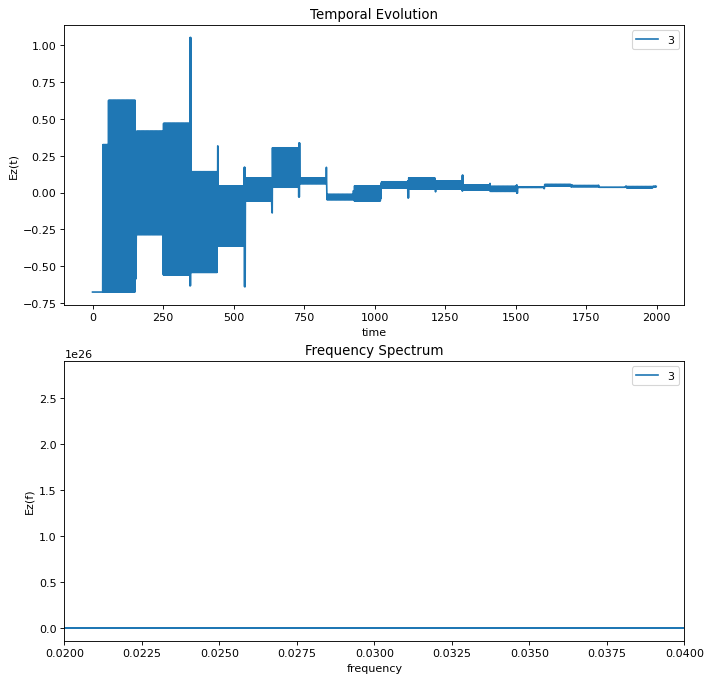

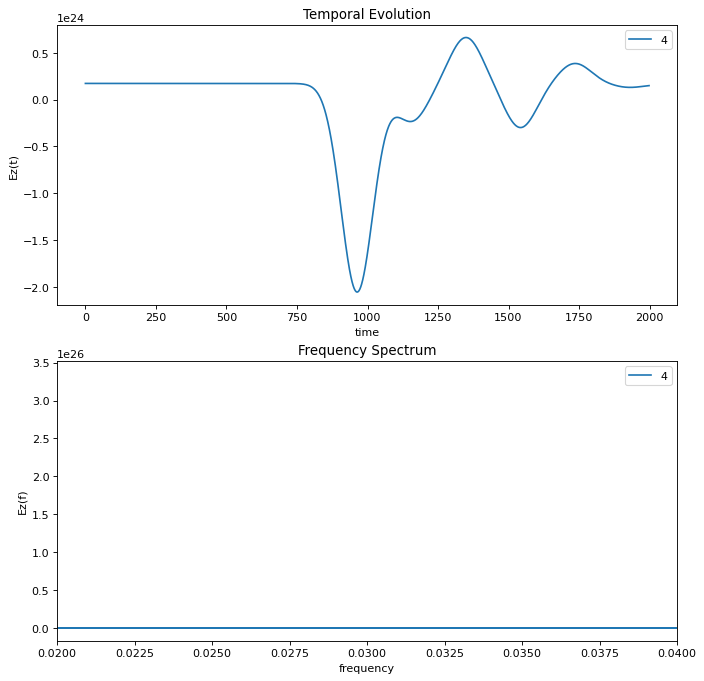

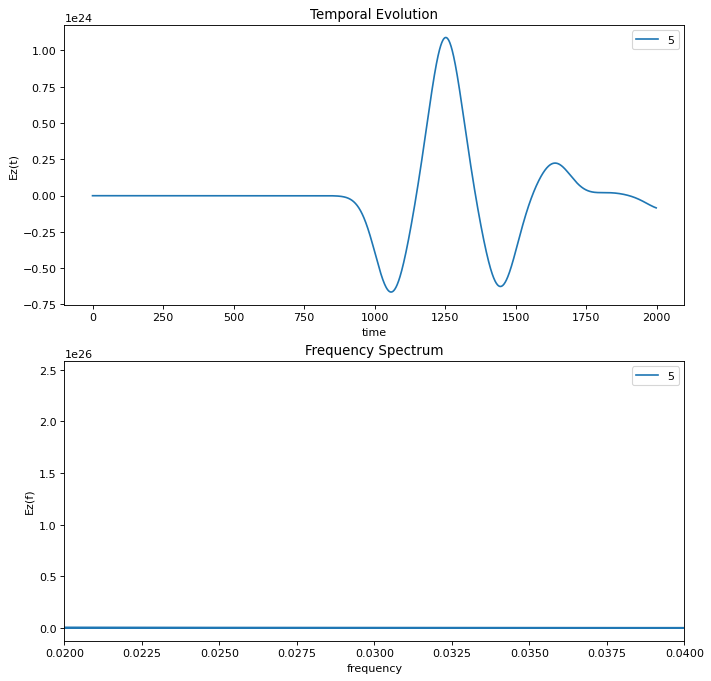

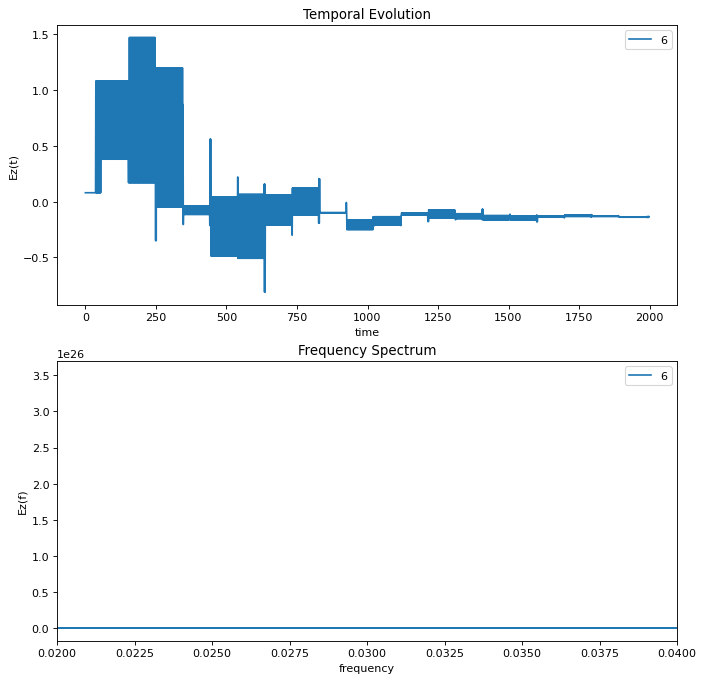

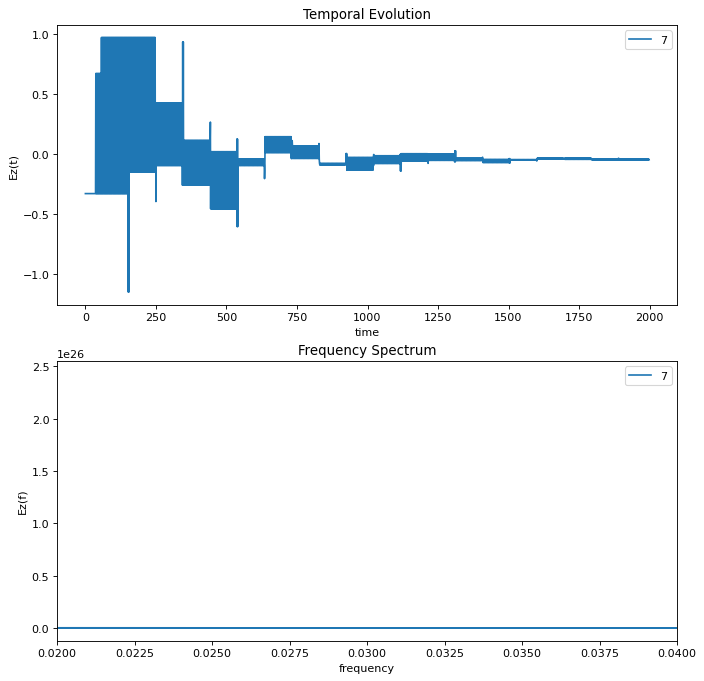

In [135]:
Ez = np.zeros((maxTime-1,SIZE), dtype=complex)
yf = np.zeros((maxTime-1,SIZE), dtype=complex)
N = maxTime-1
T = 1
xf = fftfreq(N,T)

for ii in range(N_seg):
    filename = f"ez_tab_{ii:04d}.csv"
    df = pd.read_csv(filename)
    # print(df.shape)
    
    Ez[:,ii] = df.iloc[:,60]   #all rows of the 10th spatial point
    Ez[:,ii] -= np.mean(Ez[:,ii])
    
    yf[:,ii] = abs(fft(Ez[:,ii]))
    
    #accessing particular columns - all elements(all time steps for a particular spatial coordinate.)
x = range(len(df.iloc[0,:])) 
print(x)   

for ii in range(N_seg):
    figure(figsize=(10, 10), dpi=80)
    plt.subplot(2,1,1)
    plt.plot(Ez[:,ii], label={ii})
    plt.title("Temporal Evolution")
    plt.xlabel("time")
    plt.ylabel("Ez(t)")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(xf,yf[:,ii], label={ii})
    plt.xlim([0.02,0.04])
    plt.title("Frequency Spectrum")
    plt.xlabel("frequency")
    plt.ylabel("Ez(f)")
    plt.legend()
    plt.show()

10


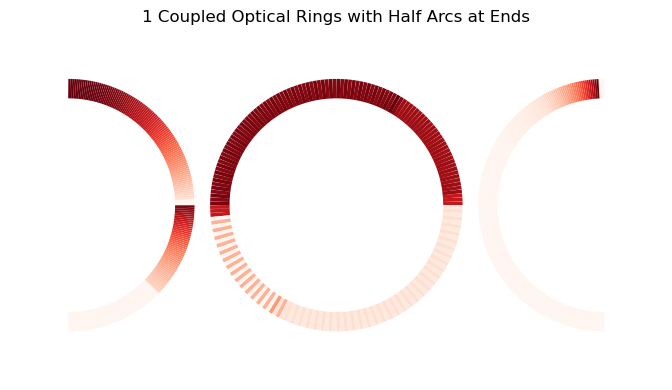

10


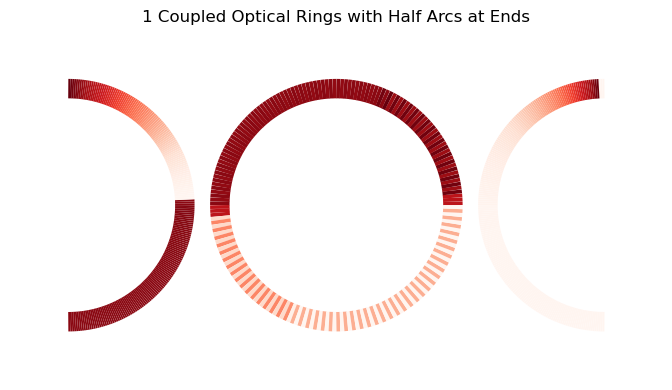

10


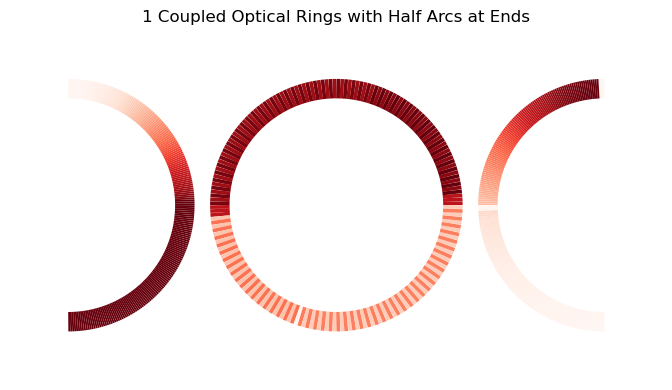

10


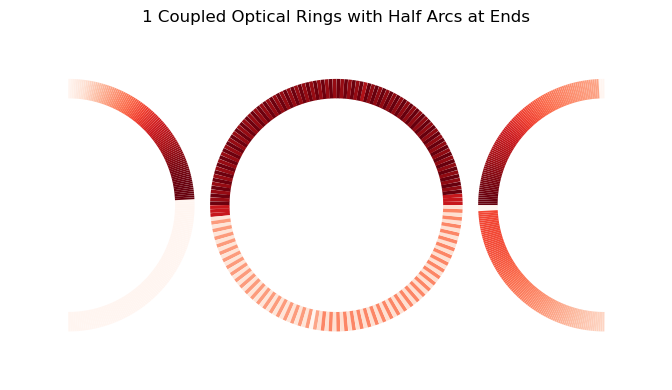

10


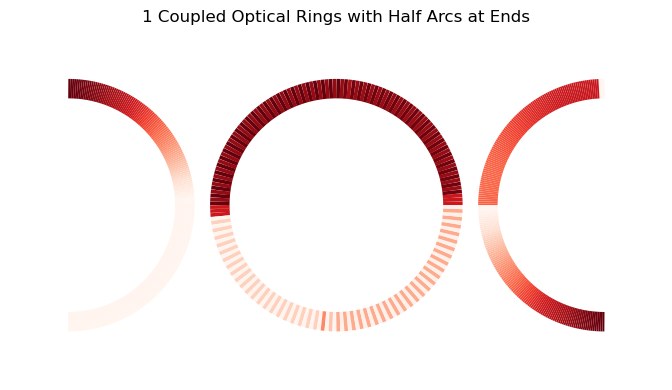

In [114]:
# Parameters

for tp in range(900,1350,100):
    ez_tab_tp = ez_tab[:,tp,:]
    plot_field_ring(ez_tab_tp)

